In [ ]:
### import numpy as np
import sys
sys.path.append("../src/utils")
from load_repositories import *
import load_repositories

import os
import pickle 
from rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation
import shap
from sklearn.metrics import accuracy_score, auc, average_precision_score, precision_recall_curve, roc_auc_score
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

Load data

In [2]:
data_root = os.path.join('..','external_repos','eraserbenchmark-master','data', 'movies')
documents = load_documents(data_root)
train, val, test = load_datasets(data_root)

In [3]:
print("Train: ", len(train))
print("Val: ", len(val))
print("Test: ", len(test))

Train:  1600
Val:  200
Test:  199


In [4]:
pretrained_model = "../src/models/bert_tweets"
tokenizer = BertTokenizer.from_pretrained(pretrained_model, do_lower_case=False)
model = BertForSequenceClassification.from_pretrained(pretrained_model)
model.eval()
label_names = ["Positive", "Neutral", "Negative"]

In [5]:
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None
)
explainer = shap.Explainer(pred)

In [6]:
def map_tokens(shap_values, doc_tokens):
    i = 0
    j = 0
    n = shap_values.data[0].size
    m = len(doc_tokens)
    tokens_map = []
    
    while i < n and j < m:
        model_token = shap_values.data[0][i].strip()
        
        if model_token == doc_tokens[j]:
            tokens_map.append(j)
            j += 1
        elif model_token == "":
            tokens_map.append(None)
        else:
            found = False
            
            for k in range(1,5):
                if (i + k < n):
                    merged_token = model_token
    
                    for l in range(1,k+1):
                        merged_token += shap_values.data[0][i+l].strip()
                    
                    if merged_token == doc_tokens[j]:
                        found = True
                        
                        for l in range(1,k+2):
                            tokens_map.append(j)
                    
                        j += 1
                        i += k
                        break
            
        i += 1

    return tokens_map

In [7]:
def merge_owen_for_tokens(owen_values, tokens_map):
    new_owen = [owen_values[0]]
    last_position = 0

    for i in range(1, len(tokens_map)):
        if (tokens_map[i-1] is None) or (tokens_map[i-1]==tokens_map[i]):           
            new_owen[last_position] += owen_values[i]
        else:
            last_position += 1
            new_owen.append(owen_values[i])

    return new_owen

In [8]:
def prepare_truth_pred_dicts(pred_owens, evidences):
    pred = {}
    truth = {}
    evidences_tokens = []
    len_tokens = len(pred_owens)

    for ev in evidences:
        if ev.start_token <= len_tokens:
            #start_token = tokens_map_reversed[ev.start_token][0]
            start_token = ev.start_token
    
            if ev.end_token <= len_tokens-1:
                end_token = ev.end_token
            else:
                end_token = len_tokens-1
                 
            evidences_tokens += list(range(start_token, end_token+1))

    for i in range(len(pred_owens)):
        pred[i] = pred_owens[i]

        if i in evidences_tokens:
            truth[i] = True
        else:
            truth[i] = False
        
    return truth, pred

In [9]:
def prepare_truth_pred_lists(pred_owens, evidences):
    evidences_tokens = []
    len_tokens = len(pred_owens)

    for ev in evidences:
        if ev.start_token <= len_tokens:
            #start_token = tokens_map_reversed[ev.start_token][0]
            start_token = ev.start_token
    
            if ev.end_token <= len_tokens-1:
                end_token = ev.end_token
            else:
                end_token = len_tokens-1
                 
            evidences_tokens += list(range(start_token, end_token+1))

    truth = [(i in evidences_tokens) for i in range(len(pred_owens))]        
    return truth, pred_owens

In [12]:
# def auprc(truth: Dict[Any, List[bool]], preds: Dict[Any, List[float]]) -> float:
#     if len(preds) == 0:
#         return 0.0
#     assert len(truth.keys() and preds.keys()) == len(truth.keys())
#     aucs = []
#     for k, true in truth.items():
#         pred = preds[k]
#         true = [int(t) for t in true]
#         precision, recall, _ = precision_recall_curve(true, pred)
#         aucs.append(auc(recall, precision))
#     return np.average(aucs)

NameError: name 'Dict' is not defined

In [18]:
docs_owen = {}
i = 0
print(i)
annotation = test[i]
evidences = annotation.all_evidences()
(docid,) = set(ev.docid for ev in evidences)
doc = documents[docid]
sentences = []

for sent in doc:
    sentence = ' '.join(sent)
    sentences.append(sentence)

doc_text = ' '.join(sentences)
total_tokens = tokenizer(doc_text)
n_tokens = len(total_tokens['input_ids'])
print(f"{len(sentences)} sentences, {n_tokens} token")

if n_tokens > 512:
    rel_tokens = 512/n_tokens
    n_sents = int(rel_tokens * len(sentences)) - 3
    doc_text1 = ' '.join(sentences[:n_sents])
    tokens1 = tokenizer(doc_text1)
    print(f"{n_sents} sentences, {len(tokens1['input_ids'])} token")
else:
    doc_text1 = doc_text
    tokens1 = total_tokens

shap_values = explainer([doc_text1])
docs_owen[docid] = shap_values

file_pi = open('test_docs_owen.pkl', 'wb') 
pickle.dump(docs_owen, file_pi)

0
26 sentences, 699 token
16 sentences, 510 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:58, 418.49s/it]                                                                  


NameError: name 'doc_tokens' is not defined

In [19]:
doc_tokens = []

for sent in doc:
    doc_tokens += sent

tokens_map = map_tokens(shap_values, doc_tokens)
owen_values = shap_values.values[0,:,2]

IndexError: list index out of range

In [33]:
new_owen = [owen_values[0]]
last_position = 0

for i in range(1, len(tokens_map)):
    if (tokens_map[i-1] is None) or (tokens_map[i-1]==tokens_map[i]):
        print(f"{i} - {last_position}")
        new_owen[last_position] += owen_values[i]
    else:
        last_position += 1
        new_owen.append(owen_values[i])

1 - 0
10 - 8
16 - 13
28 - 24
36 - 31
44 - 38
53 - 46
57 - 49
65 - 56
66 - 56
78 - 67
95 - 83
96 - 83
107 - 93
108 - 93
117 - 101
124 - 107
125 - 107
146 - 127
159 - 139
187 - 166
206 - 184
207 - 184
219 - 195
220 - 195
226 - 200
242 - 215
243 - 215
249 - 220
250 - 220
252 - 221
282 - 250
295 - 262
296 - 262
304 - 269
310 - 274
311 - 274
317 - 279
327 - 288
361 - 321
373 - 332
383 - 341
406 - 363
408 - 364
409 - 364
417 - 371
419 - 372
420 - 372
430 - 381
444 - 394
480 - 429
506 - 454
507 - 454


In [35]:
pred_owens = merge_owen_for_tokens(owen_values, tokens_map)

616

In [49]:
truth, pred = prepare_truth_pred_lists(pred_owens, evidences)
# #doc_auprc = 
# if len(preds) == 0:
#         return 0.0
#     assert len(truth.keys() and preds.keys()) == len(truth.keys())
aucs = []
# for k, true in truth.items():
#     pred = preds[k]
#     true = [int(t) for t in true]


In [52]:
precision, recall, _ = precision_recall_curve(truth, pred)
aucs.append(auc(recall, precision))
print("auprc" , np.average(aucs))

auprc 0.1977449861584782


Explain and save

In [53]:
for i in range(1,50):
    print(i)
    annotation = test[i]
    evidences = annotation.all_evidences()
    (docid,) = set(ev.docid for ev in evidences)
    doc = documents[docid]
    sentences = []
    
    for sent in doc:
        sentence = ' '.join(sent)
        sentences.append(sentence)

    doc_text = ' '.join(sentences)
    total_tokens = tokenizer(doc_text)
    n_tokens = len(total_tokens['input_ids'])
    print(f"{len(sentences)} sentences, {n_tokens} token")
    
    if n_tokens > 512:
        rel_tokens = 512/n_tokens
        n_sents = int(rel_tokens * len(sentences)) - 1
        doc_text1 = ' '.join(sentences[:n_sents])
        tokens1 = tokenizer(doc_text1)

        while len(tokens1['input_ids']) > 512:
            n_sents -= 1
            doc_text1 = ' '.join(sentences[:n_sents])
            tokens1 = tokenizer(doc_text1)
        
        print(f"{n_sents} sentences, {len(tokens1['input_ids'])} token")
    else:
        doc_text1 = doc_text
        tokens1 = total_tokens
    
    shap_values = explainer([doc_text1])
    docs_owen[docid] = shap_values

    file_pi = open('test_docs_owen_x.pkl', 'wb') 
    pickle.dump(docs_owen, file_pi)

1
18 sentences, 449 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:08, 368.38s/it]                                                                  


2
46 sentences, 898 token
22 sentences, 491 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:47, 407.13s/it]                                                                  


3
18 sentences, 398 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:27, 327.15s/it]                                                                  


4
10 sentences, 283 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:35, 215.76s/it]                                                                  


5
33 sentences, 818 token
18 sentences, 508 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:53, 413.83s/it]                                                                  


6
43 sentences, 1028 token
20 sentences, 464 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:16, 376.59s/it]                                                                  


7
32 sentences, 807 token
19 sentences, 495 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:45, 405.77s/it]                                                                  


8
55 sentences, 1113 token
24 sentences, 465 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:10, 370.82s/it]                                                                  


9
21 sentences, 486 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:29, 389.47s/it]                                                                  


10
34 sentences, 772 token
20 sentences, 493 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:35, 395.13s/it]                                                                  


11
49 sentences, 1047 token
22 sentences, 412 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:32, 332.64s/it]                                                                  


12
70 sentences, 1393 token
18 sentences, 512 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:52, 412.19s/it]                                                                  


13
22 sentences, 565 token
18 sentences, 474 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:21, 381.44s/it]                                                                  


14
28 sentences, 602 token
21 sentences, 487 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:36, 396.13s/it]                                                                  


15
27 sentences, 691 token
19 sentences, 456 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:02, 362.49s/it]                                                                  


16
44 sentences, 642 token
33 sentences, 505 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:52, 412.71s/it]                                                                  


17
33 sentences, 834 token
19 sentences, 505 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:44, 404.76s/it]                                                                  


18
30 sentences, 798 token
18 sentences, 509 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:54, 414.77s/it]                                                                  


19
25 sentences, 571 token
21 sentences, 482 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:36, 396.04s/it]                                                                  


20
13 sentences, 453 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:59, 359.51s/it]                                                                  


21
35 sentences, 1224 token
13 sentences, 484 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:27, 387.49s/it]                                                                  


22
21 sentences, 414 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:34, 334.77s/it]                                                                  


23
44 sentences, 981 token
21 sentences, 470 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:23, 383.61s/it]                                                                  


24
28 sentences, 722 token
18 sentences, 501 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:42, 402.73s/it]                                                                  


25
36 sentences, 645 token
27 sentences, 497 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:49, 409.36s/it]                                                                  


26
94 sentences, 1906 token
24 sentences, 496 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:34, 394.95s/it]                                                                  


27
46 sentences, 1019 token
20 sentences, 500 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:51, 411.19s/it]                                                                  


28
65 sentences, 1497 token
21 sentences, 502 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:50, 410.93s/it]                                                                  


29
23 sentences, 371 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:54, 294.85s/it]                                                                  


30
26 sentences, 589 token
19 sentences, 504 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:45, 405.38s/it]                                                                  


31
20 sentences, 527 token
18 sentences, 511 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [07:07, 427.49s/it]                                                                  


32
41 sentences, 564 token
36 sentences, 500 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:39, 399.52s/it]                                                                  


33
53 sentences, 1771 token
14 sentences, 502 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:45, 405.90s/it]                                                                  


34
46 sentences, 1144 token
15 sentences, 473 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:20, 380.48s/it]                                                                  


35
37 sentences, 1084 token
16 sentences, 407 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:27, 327.93s/it]                                                                  


36
33 sentences, 659 token
24 sentences, 468 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:25, 385.37s/it]                                                                  


37
35 sentences, 658 token
26 sentences, 498 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:43, 403.71s/it]                                                                  


38
36 sentences, 712 token
22 sentences, 461 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:15, 375.35s/it]                                                                  


39
21 sentences, 586 token
17 sentences, 478 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:27, 387.72s/it]                                                                  


40
17 sentences, 212 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:53, 173.65s/it]                                                                  


41
64 sentences, 868 token
29 sentences, 506 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:44, 404.38s/it]                                                                  


42
38 sentences, 873 token
21 sentences, 475 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:26, 386.15s/it]                                                                  


43
27 sentences, 597 token
22 sentences, 490 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:40, 400.33s/it]                                                                  


44
55 sentences, 907 token
22 sentences, 505 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:44, 404.52s/it]                                                                  


45
25 sentences, 661 token
18 sentences, 471 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:19, 379.22s/it]                                                                  


46
37 sentences, 873 token
20 sentences, 408 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:28, 328.47s/it]                                                                  


47
22 sentences, 375 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:50, 290.65s/it]                                                                  


48
51 sentences, 772 token
32 sentences, 461 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:10, 370.68s/it]                                                                  


49
53 sentences, 1019 token
25 sentences, 488 token


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [33:13, 1993.65s/it]                                                                 


Load saved scores

In [10]:
file_pi = open('test_docs_owen_x.pkl', 'rb') 
docs_owen = pickle.load(file_pi)
docs_owen

{'negR_900.txt': .values =
 array([[[-1.46201725e-04,  7.44138951e-05,  7.17883657e-05],
         [-1.46201725e-04,  7.44138951e-05,  7.17883657e-05],
         [-1.46201725e-04,  7.44138951e-05,  7.17883657e-05],
         ...,
         [-7.44060127e-05,  1.84634544e-04, -1.10228795e-04],
         [-7.44060127e-05,  1.84634544e-04, -1.10228795e-04],
         [-7.44060127e-05,  1.84634544e-04, -1.10228795e-04]]])
 
 .base_values =
 array([[0.00381243, 0.98589754, 0.01029   ]])
 
 .data =
 (array(['', ' there', ' may', ' not', ' be', ' a', ' critic', ' alive',
        ' who', ' harbor', 's', ' as', ' much', ' affection', ' for',
        ' sh', 'lock', ' monster', ' movies', ' as', ' i', ' do', ' .',
        ' i', ' delighted', ' in', ' the', ' sneak', 'y', ' -', ' smart',
        ' entertainment', ' of', ' ron', ' underwood', " '", ' s', ' big',
        ' -', ' underground', ' -', ' worm', ' yarn', ' tremor', 's', ' ;',
        ' i', ' even', ' giggled', ' at', ' last', ' year', " '", ' s

Evaluate

In [18]:
docs_auc = []

for i in range(1,50):
    print(i)
    annotation = test[i]
    evidences = annotation.all_evidences()
    (docid,) = set(ev.docid for ev in evidences)
    doc = documents[docid]
    sentences = []
    
    for sent in doc:
        sentence = ' '.join(sent)
        sentences.append(sentence)

    doc_text = ' '.join(sentences)
    total_tokens = tokenizer(doc_text)
    n_tokens = len(total_tokens['input_ids'])
    n_sents = len(sentences)
    
    if n_tokens > 512:
        rel_tokens = 512/n_tokens
        n_sents = int(rel_tokens * len(sentences)) - 1
        doc_text1 = ' '.join(sentences[:n_sents])
        tokens1 = tokenizer(doc_text1)

        while len(tokens1['input_ids']) > 512:
            n_sents -= 1
            doc_text1 = ' '.join(sentences[:n_sents])
            tokens1 = tokenizer(doc_text1)
    else:
        doc_text1 = doc_text
        tokens1 = total_tokens

    doc_tokens = []

    i_sent = 0
    
    for sent in doc:
        if i_sent < n_sents:
            doc_tokens += sent
            i_sent += 1

    shap_values = docs_owen[docid]
    tokens_map = map_tokens(shap_values, doc_tokens)

    if annotation.classification == "NEG":
        label_num = 2
    else:
        label_num = 0
    
    owen_values = shap_values.values[0,:,label_num]
    pred_owens = merge_owen_for_tokens(owen_values, tokens_map)
    truth, pred = prepare_truth_pred_lists(pred_owens, evidences)
    aucs = []
    precision, recall, _ = precision_recall_curve(truth, pred)
    auprc = auc(recall, precision)
    #aucs.append(auc(recall, precision))
    #doc_auc = np.average(aucs)
    #print("auprc" , doc_auc)
    print("auprc ", auprc)
    docs_auc.append(auprc)

print("Mean auprc" , np.mean(docs_auc))

1
auprc  0.7053084353660446
2
auprc  0.5823284453560287
3
auprc  0.6838709470059285
4
auprc  0.5023823065153694
5
auprc  0.1248992506493353
6
auprc  0.31395056834965357
7
auprc  0.42992918182431955
8
auprc  0.10804645182099397
9
auprc  0.41966235167198296
10


C:\Users\eliag\Documents\Msc\Thesis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


auprc  0.5
11
auprc  0.12518045839325997
12
auprc  0.04583811195091957
13
auprc  0.3631009112246993
14
auprc  0.25031401654110996
15
auprc  0.15471476812877316
16
auprc  0.6964127778655003
17
auprc  0.6279124741929609
18
auprc  0.3330205612089777
19
auprc  0.4412682068889948
20
auprc  0.6989266289554026
21
auprc  0.5876670412990231
22
auprc  0.37350873676710616
23
auprc  0.21552888355944072
24
auprc  0.31089724395062246
25
auprc  0.2407878141766761
26
auprc  0.43366832894577956
27
auprc  0.21408554676589223
28
auprc  0.4446449847572148
29
auprc  0.2853200978942511
30
auprc  0.22116538851662154
31
auprc  0.6286043579015353
32
auprc  0.2717494900130425
33
auprc  0.7219936400102258
34
auprc  0.3533617171114355
35
auprc  0.11212311476743955
36
auprc  0.38972034661310007
37
auprc  0.8063848375082108
38
auprc  0.20530712047323219
39
auprc  0.08390138169349665
40
auprc  0.9934034541598925
41
auprc  0.3968912411119174
42
auprc  0.5778501483588161
43
auprc  0.7896309955717872
44
auprc  0.428796

In [64]:
print("STD" , np.std(docs_auc))

STD 0.23090609438073922


In [14]:
truth

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,


In [68]:
def get_doc_owens(i):
    annotation = test[i]
    evidences = annotation.all_evidences()
    (docid,) = set(ev.docid for ev in evidences)
    doc = documents[docid]
    sentences = []
    
    for sent in doc:
        sentence = ' '.join(sent)
        sentences.append(sentence)

    doc_text = ' '.join(sentences)
    total_tokens = tokenizer(doc_text)
    n_tokens = len(total_tokens['input_ids'])
    n_sents = len(sentences)
    
    if n_tokens > 512:
        rel_tokens = 512/n_tokens
        n_sents = int(rel_tokens * len(sentences)) - 1
        doc_text1 = ' '.join(sentences[:n_sents])
        tokens1 = tokenizer(doc_text1)

        while len(tokens1['input_ids']) > 512:
            n_sents -= 1
            doc_text1 = ' '.join(sentences[:n_sents])
            tokens1 = tokenizer(doc_text1)
    else:
        doc_text1 = doc_text
        tokens1 = total_tokens

    doc_tokens = []

    i_sent = 0
    
    for sent in doc:
        if i_sent < n_sents:
            doc_tokens += sent
            i_sent += 1

    shap_values = docs_owen[docid]
    tokens_map = map_tokens(shap_values, doc_tokens)

    if annotation.classification == "NEG":
        label_num = 2
    else:
        label_num = 0
    
    owen_values = shap_values.values[0,:,label_num]
    return owen_values, evidences, tokens_map, doc_tokens

AUPRC of all 50 test docs

In [69]:
all_truth = []
all_preds = []

for i in range(1,50):
    owen_values, evidences, tokens_map, doc_tokens = get_doc_owens(i)
    pred_owens = merge_owen_for_tokens(owen_values, tokens_map)
    truth, pred = prepare_truth_pred_lists(pred_owens, evidences)
    all_truth += truth
    all_preds += pred

precision, recall, _ = precision_recall_curve(all_truth, all_preds)
auprc = auc(recall, precision)
print("Mean auprc" , auprc)

Mean auprc 0.4134927590369928


In [67]:
len(pred)

454

Visualize a good and a bad example

In [95]:
from IPython.display import display, HTML
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import html

def scale_for_opacity(scores, min_o, max_o):
    min_score = min(scores)
    max_score = max(scores)
    score_diff = max_score - min_score
    o_diff = max_o - min_o
    opacity_scores = [(((score - min_score) / score_diff) * o_diff + min_o) for score in scores]
    return opacity_scores

def highlight_text(tokens, importance, binary_marking, cmap_name='coolwarm', max_opacity=0.9, min_opacity=0.2):
    """
    Highlights parts of text based on importance values.

    Parameters:
        tokens (list of str): List of words or tokens in the text.
        importance (list of float): List of importance scores for each token (same length as `tokens`).
        cmap_name (str): Name of the matplotlib colormap to use for highlighting.
        max_opacity (float): Maximum opacity for the highlights (values from 0 to 1).
    
    Returns:
        None: Displays the highlighted text in the notebook.
    """
    
    # Normalize importance values to a 0-1 range
    norm = mcolors.Normalize(vmin=min(importance), vmax=max(importance))
    #cmap = mcolors.Colormap(cmap_name)
    cmap = cm.get_cmap(cmap_name)  # Get a concrete colormap instance
    opacity_scores = scale_for_opacity(importance, min_opacity, max_opacity)
    
    # Build HTML with spans for highlighting
    highlighted_text = ""
    for token, score, opacity, truth in zip(tokens, importance, opacity_scores, binary_marking):
        rgba = cmap(norm(score))
        color = mcolors.to_hex(rgba)
        escaped_token = html.escape(token)
        #opacity = 0.5
        # Add underline if binary_marking indicates it
        style = f"background-color:{color};opacity:{opacity};padding:2px;"
        if truth:
            style += "font-weight:bold;"

        highlighted_text += f'<span style="{style}">{escaped_token}</span> '
    
    # Display the highlighted text
    display(HTML(f'<div style="font-family:monospace;font-size:16px;">{highlighted_text}</div>'))

In [96]:
highlight_text(doc_tokens, pred, truth)

C:\Users\eliag\AppData\Local\Temp\ipykernel_30612\3715649949.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)  # Get a concrete colormap instance


### Distributions and analytics

auprc graph

Text(0.5, 1.0, 'Precision-Recall Curve')

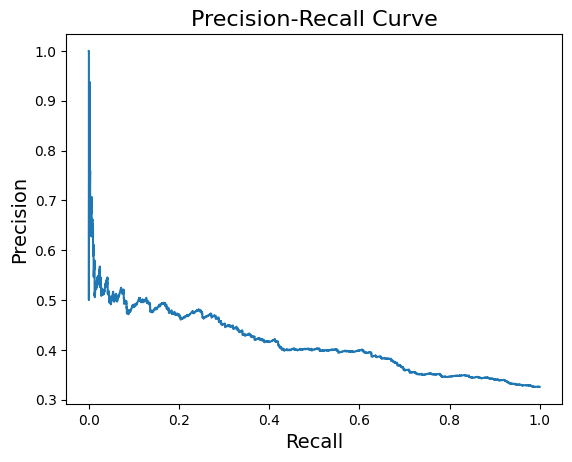

In [103]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)

How many of the reviews tokens are marked as evidences

In [100]:
all_truth_arr = np.array(all_truth)
all_truth_arr.sum() / len(all_truth_arr)

0.325874613774544

% of evidences in different reviews

In [105]:
docs_truth = []
docs_preds = []
evidence_rate = []

for i in range(1,50):
    owen_values, evidences, tokens_map, doc_tokens = get_doc_owens(i)
    pred_owens = merge_owen_for_tokens(owen_values, tokens_map)
    truth, pred = prepare_truth_pred_lists(pred_owens, evidences)
    docs_truth.append(truth)
    docs_preds.append(pred)
    
    truth_arr = np.array(truth)
    evidence_rate.append(truth_arr.sum() / len(truth_arr))

Text(0.5, 1.0, '% of evidence - histogram')

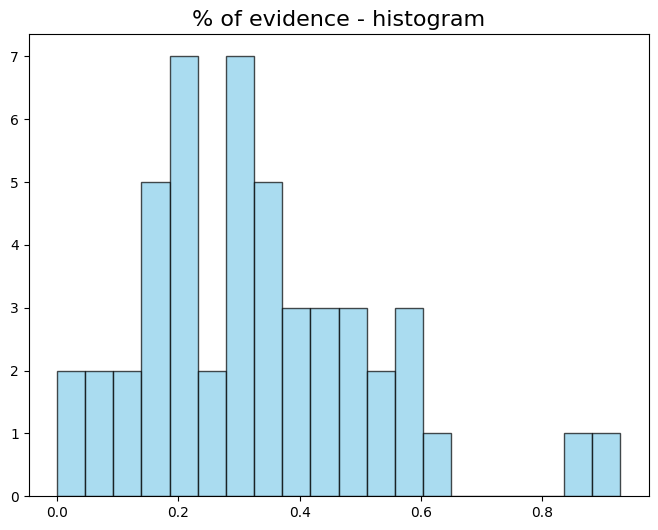

In [108]:
counts, bins = np.histogram(evidence_rate, bins=20)
plt.figure(figsize=(8, 6)) 
plt.hist(bins[:-1], bins, weights=counts, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('% of evidence - histogram', fontsize=16)

Owen values distribution

Text(0.5, 1.0, 'Owen values distibution (50 docs)')

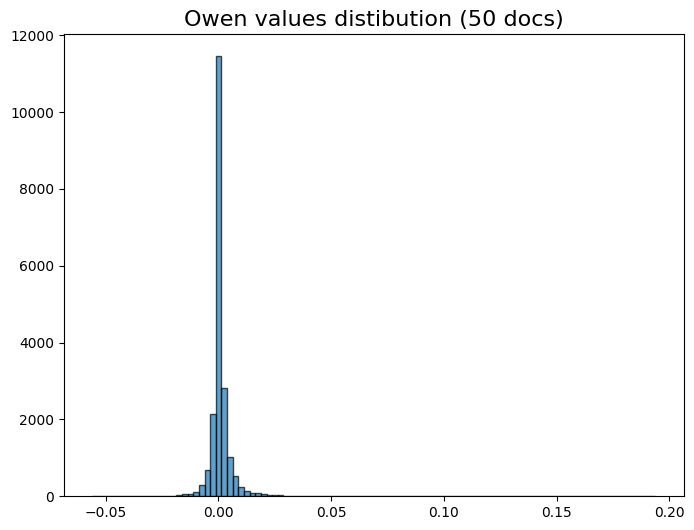

In [111]:
counts, bins = np.histogram(all_preds, bins=100)
plt.figure(figsize=(8, 6)) 
plt.hist(bins[:-1], bins, weights=counts, edgecolor='black', alpha=0.7)
plt.title('Owen values distibution (50 docs)', fontsize=16)

Text(0.5, 1.0, 'Owen values distibution (50 docs)')

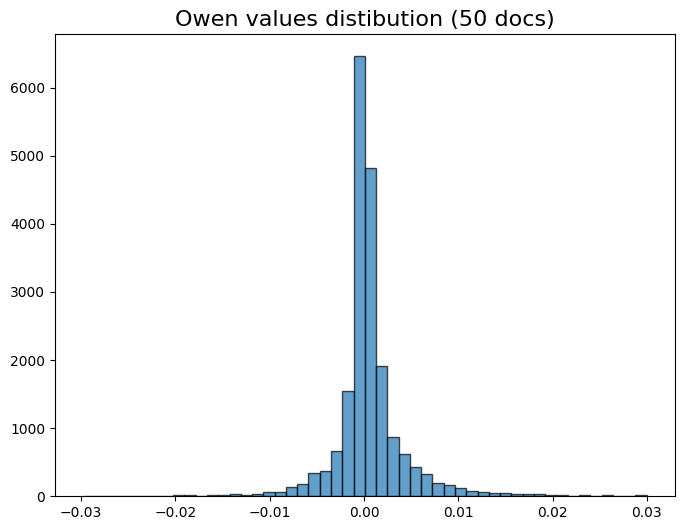

In [117]:
all_preds_trim = [p for p in all_preds if np.abs(p)<0.03]
counts, bins = np.histogram(all_preds_trim, bins=50)
plt.figure(figsize=(8, 6)) 
plt.hist(bins[:-1], bins, weights=counts, edgecolor='black', alpha=0.7)
plt.title('Owen values distibution (50 docs)', fontsize=16)

Owen values of evidences vs owen values of non evidences tokens

In [113]:
ev_owens = []
non_ev_owens = []

for i in range(len(all_preds)):
    if all_truth[i]:
        ev_owens.append(all_preds[i])
    else:
        non_ev_owens.append(all_preds[i])

print(np.mean(ev_owens))
print(np.mean(non_ev_owens))

0.001789834023691897
0.0003365568854962872


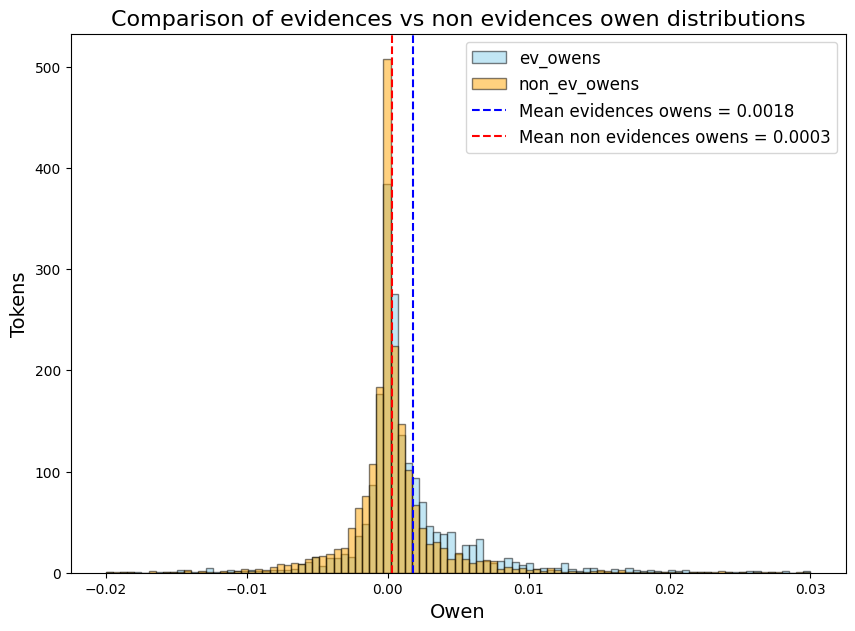

In [121]:
plt.figure(figsize=(10, 7)) 
bins = np.linspace(-0.02, 0.03, 100)  # Define common bins for both distributions
plt.hist(ev_owens, bins, alpha=0.5, label='ev_owens', color='skyblue', edgecolor='black', density=True)
plt.hist(non_ev_owens, bins, alpha=0.5, label='non_ev_owens', color='orange', edgecolor='black', density=True)

# Add vertical lines for means
mean_ev_owens = np.mean(ev_owens)
mean_non_ev_owens = np.mean(non_ev_owens)
plt.axvline(mean_ev_owens, color='blue', linestyle='--', linewidth=1.5, label=f'Mean evidences owens = {mean_ev_owens:.4f}')
plt.axvline(mean_non_ev_owens, color='red', linestyle='--', linewidth=1.5, label=f'Mean non evidences owens = {mean_non_ev_owens:.4f}')

# Add title, labels, and legend
plt.title('Comparison of evidences vs non evidences owen distributions', fontsize=16)
plt.xlabel('Owen', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.legend(fontsize=12)